In [ ]:
# !pip install tensorflow[and-cuda]
# !pip install pandas
# !pip install yfinance
# !pip install scikit-learn  
# !pip install plotly
# !pip install imblearn
# !pip install seaborn
# !pip install keras-tuner
# !pip install --upgrade nbformat
# !pip install scikit-learn tensorflow
# !pip install keras
# !pip install scikeras
# !pip install scikeras[tensorflow]
# !pip install scikeras tensorflow

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinancetool as yft
import techinal_indicato as ti
import model_logistic_regression as ml
import plots
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2,f_classif
import importlib
importlib.reload(ti)
importlib.reload(yft)
importlib.reload(ml)
importlib.reload(plots)



<module 'plots' from 'd:\\UH\\DataScienceProject\\DataScienceProject\\code\\plots.py'>

##Pre-preocessing

In [13]:

importlib.reload(ti)
importlib.reload(yft)
importlib.reload(ml)
importlib.reload(plots)

# Set the download path for csv
basepath = "../data/"
yfh = yft.YFinanceHelper(basepath)
tih = ti.TechinalIndicatoHelper()

# Stock data download start date
sd = '2000-01-01'
# Stock data download end date
ed = '2023-12-31' #'1999-12-31'#'2023-12-31'

# Traning data start with sd to below date and remaning date will be used for testing
training_end_date_Str = '2021-12-31'


#appl
#"MSFT" #PFE, AAPL, MSFT, NVDA, AVGO (Broadcom Inc), ORCL

# Download dataset
stock_df_with_indecators_MSFT = tih.get_dataset(yfh,"MSFT",sd,ed,28)  # .apply_techinal_indicators(stock_df, 28)
# stock_df_with_indecators_AAPL = tih.get_dataset(yfh,"AAPL",sd,ed,28)
# stock_df_with_indecators_ORCL = tih.get_dataset(yfh,"ORCL",sd,ed,28)  # .apply_techinal_indicators(stock_df, 28)
# stock_df_with_indecators_NVDA = tih.get_dataset(yfh,"NVDA",sd,ed,28)
# stock_df_with_indecators_PFE = tih.get_dataset(yfh,"PFE",sd,ed,28)
# stock_df_with_indecators_MARUTI = tih.get_dataset(yfh,"MARUTI.NS",sd,ed,28)


# Split data for traning for ml and test model after traning
training_stock_df_with_indecators_MSFT = stock_df_with_indecators_MSFT[(stock_df_with_indecators_MSFT['Date'] < pd.to_datetime(training_end_date_Str))]
testing_stock_df_with_indecators_MSFT = stock_df_with_indecators_MSFT[(stock_df_with_indecators_MSFT['Date'] >= pd.to_datetime(training_end_date_Str))]

# training_stock_df_with_indecators_AAPL = stock_df_with_indecators_AAPL[(stock_df_with_indecators_AAPL['Date'] < pd.to_datetime(training_end_date_Str))]
# testing_stock_df_with_indecators_AAPL = stock_df_with_indecators_AAPL[(stock_df_with_indecators_AAPL['Date'] >= pd.to_datetime(training_end_date_Str))]


# training_stock_df_with_indecators_ORCL = stock_df_with_indecators_ORCL[(stock_df_with_indecators_ORCL['Date'] < pd.to_datetime(training_end_date_Str))]
# testing_stock_df_with_indecators_ORCL = stock_df_with_indecators_ORCL[(stock_df_with_indecators_ORCL['Date'] >= pd.to_datetime(training_end_date_Str))]


# training_stock_df_with_indecators_NVDA = stock_df_with_indecators_NVDA[(stock_df_with_indecators_NVDA['Date'] < pd.to_datetime(training_end_date_Str))]
# testing_stock_df_with_indecators_NVDA = stock_df_with_indecators_NVDA[(stock_df_with_indecators_NVDA['Date'] >= pd.to_datetime(training_end_date_Str))]

# training_stock_df_with_indecators_PFE = stock_df_with_indecators_PFE[(stock_df_with_indecators_PFE['Date'] < pd.to_datetime(training_end_date_Str))]
# testing_stock_df_with_indecators_PFE = stock_df_with_indecators_PFE[(stock_df_with_indecators_PFE['Date'] >= pd.to_datetime(training_end_date_Str))]

# training_stock_df_with_indecators_MARUTI = stock_df_with_indecators_MARUTI[(stock_df_with_indecators_MARUTI['Date'] < pd.to_datetime(training_end_date_Str))]
# testing_stock_df_with_indecators_MARUTI = stock_df_with_indecators_MARUTI[(stock_df_with_indecators_MARUTI['Date'] >= pd.to_datetime(training_end_date_Str))]


##Class distribution

Text(0.5, 1.0, 'Class distribution')

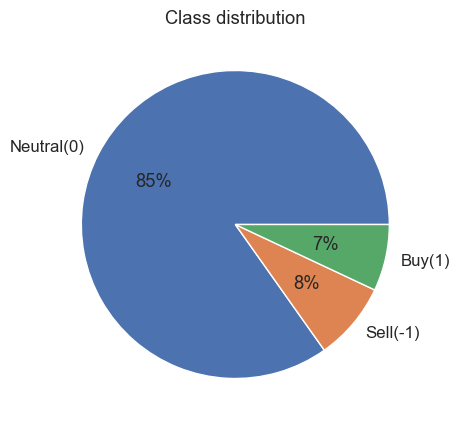

In [12]:

plt.figure(figsize=(5,5))
plt.pie(stock_df_with_indecators_MSFT['WMA VPT Signal'].value_counts(), labels=['Neutral(0)', 'Sell(-1)', 'Buy(1)'], autopct='%.0f%%') 
plt.title("Class distribution")

## Feature selection

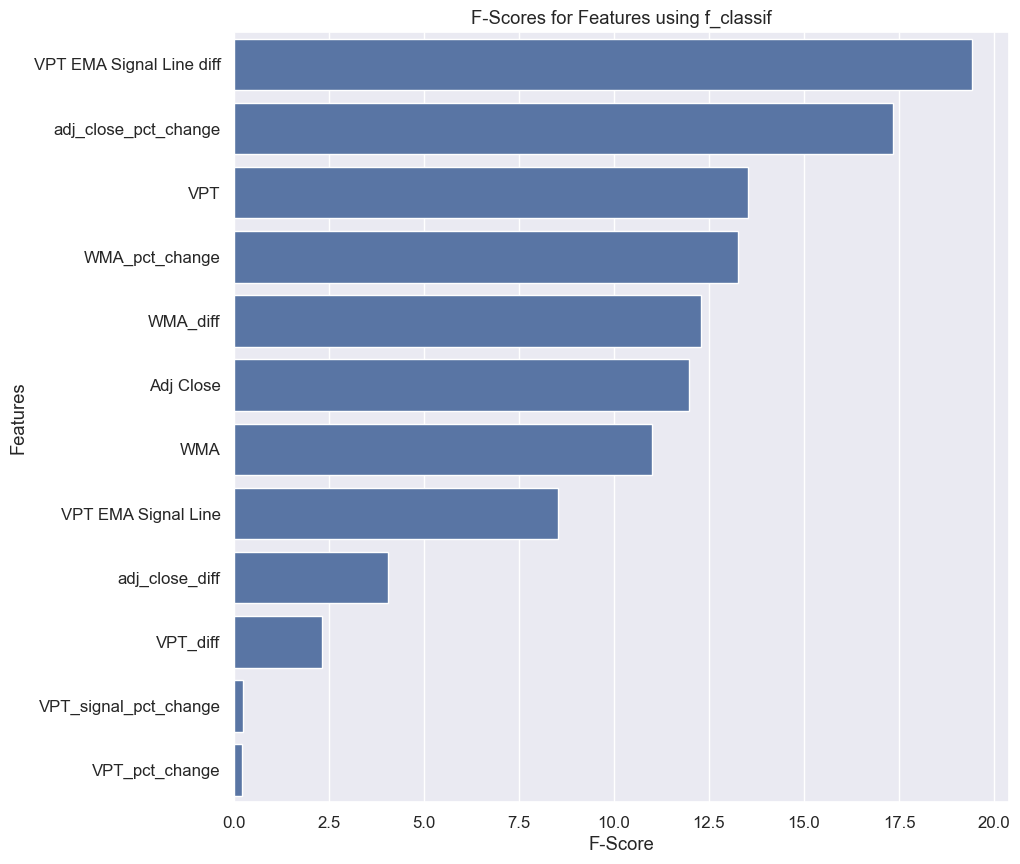

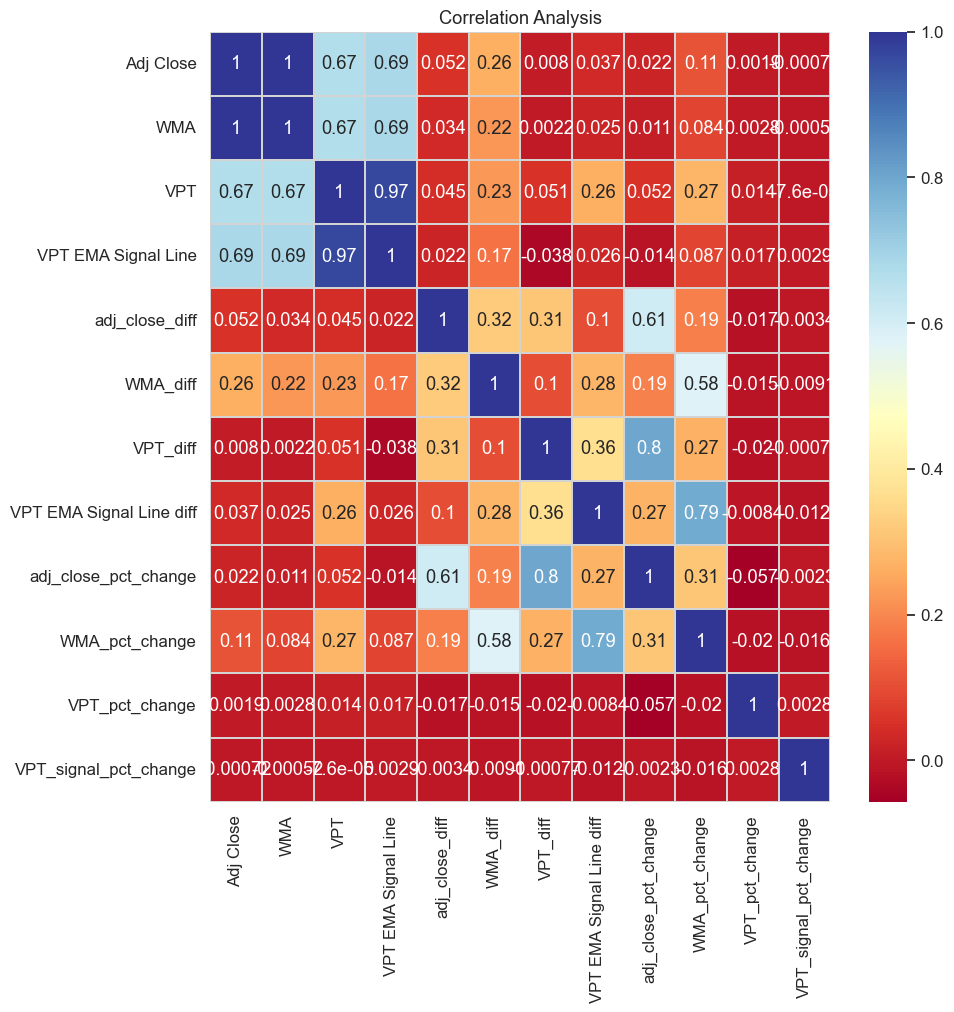

In [14]:
# Extracting features variable
X = stock_df_with_indecators_MSFT[['Adj Close','WMA','VPT','VPT EMA Signal Line','adj_close_diff','WMA_diff',"VPT_diff","VPT EMA Signal Line diff",'adj_close_pct_change', 'WMA_pct_change',"VPT_pct_change","VPT_signal_pct_change"]]#.drop(columns=['WMA Signal'])
# Exclude the target column
y = stock_df_with_indecators_MSFT['WMA VPT Signal']  # Target column

# Feature selection using SelectKBest with f_classif statistical test
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html
# For fearure can use differnt score func
selector = SelectKBest(score_func=f_classif,k='all')
X_selected = selector.fit(X, y)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
df_feature = pd.DataFrame()
df_feature["columns"]=X.columns
df_feature["scores"]=X_selected.scores_
df_feature= df_feature.sort_values(by=['scores'],ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(y=df_feature["columns"], x=df_feature["scores"])
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.title("F-Scores for Features using f_classif")

importlib.reload(plots)
plt_helper = plots.PlotHelper()
plt_helper.plot_correlation_matrix(X)

## Visualize technical indicator

MSFT WMA Signal : Final Profit: $1673.55, 16.74%
MSFT VPT Signal : Final Profit: $299.49, 2.99%
MSFT WMA VPT Signal : Final Profit: $278.94, 2.79%


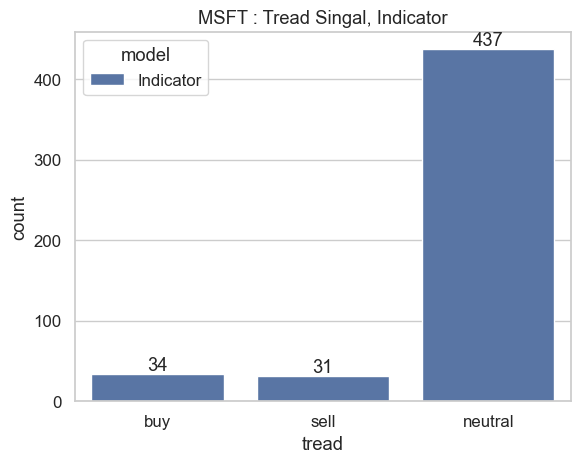

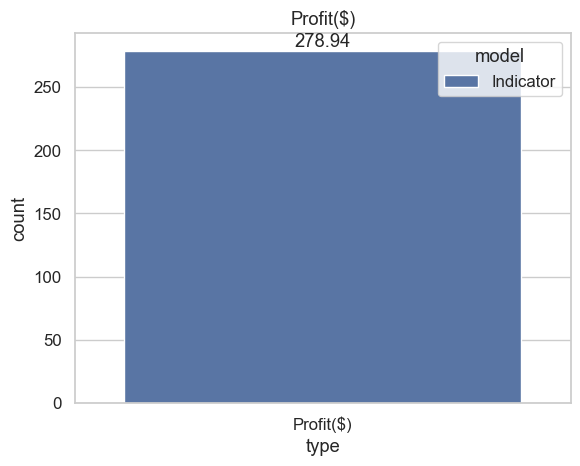

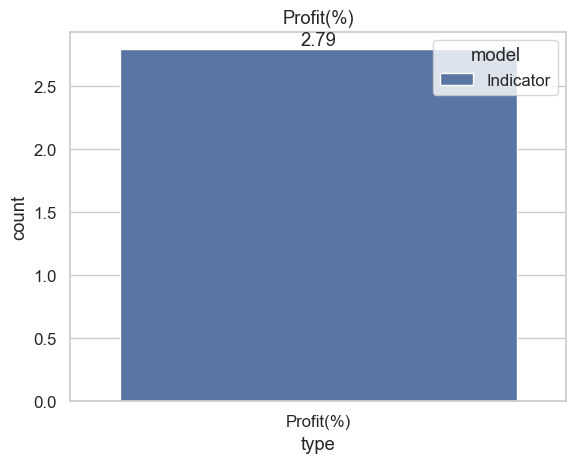

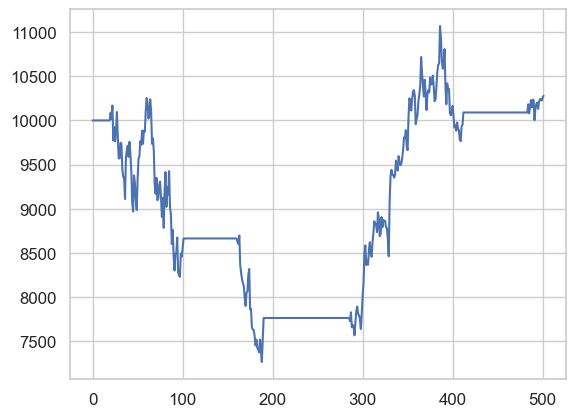

In [15]:
importlib.reload(plots)
plt_helper = plots.PlotHelper()
plt_helper.plot('MSFT','WMA Signal',testing_stock_df_with_indecators_MSFT)
plt_helper.plot_vpt('MSFT',testing_stock_df_with_indecators_MSFT)
plt_helper.plot('MSFT','WMA VPT Signal',testing_stock_df_with_indecators_MSFT)

vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_MSFT["Adj Close"],testing_stock_df_with_indecators_MSFT["WMA Signal"])
print("MSFT"+f" WMA Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_MSFT["Adj Close"],testing_stock_df_with_indecators_MSFT["VPT Signal"])
print("MSFT"+f" VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_MSFT["Adj Close"],testing_stock_df_with_indecators_MSFT["WMA VPT Signal"])
print("MSFT"+f" WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

vpt_signal_counts = testing_stock_df_with_indecators_MSFT["WMA VPT Signal"].value_counts()

df = pd.DataFrame({
'model': ["Indicator","Indicator","Indicator"],
'tread': ["buy","sell","neutral"],
'count' : [vpt_signal_counts[1],vpt_signal_counts[-1],vpt_signal_counts[0]]
})

ax = sns.barplot(df, x="tread", y="count", hue="model", legend=True)
for i in ax.containers:
    ax.bar_label(i,)
plt.title("MSFT" + " : Tread Singal, Indicator")
plt.show()


df_profit_price = pd.DataFrame({
'model': ["Indicator"],
'type': ["Profit($)"],
'count' : [vpt_profit.round(2)]
})

df_profit_pct = pd.DataFrame({
'model': ["Indicator"],
 'type': ["Profit(%)"],
'count' : [vpt_profit_percentage.round(2)]
})

    
    

ax1= sns.barplot(data = df_profit_price, x="type", y="count", hue="model", legend=True)
for i in ax1.containers:
    ax1.bar_label(i,)
plt.title("MSFT" + " : Tread Singal, Indicator")
#axes[0].set_ylim([0, 100])
ax1.set_title("Profit($)")
plt.show()

ax2 = sns.barplot(data = df_profit_pct, x="type", y="count", hue="model", legend=True)
for i in ax2.containers:
    ax2.bar_label(i,)
plt.title("MSFT" + " : Tread Singal, Indicator")
ax.set_ylim([0, 100])
ax2.set_title("Profit(%)")
plt.show()

sns.lineplot(data=vpt_portfolio_value)
plt.show()

# Model Treaning

In [16]:
importlib.reload(plots)

def print_profit(ticker_symbol,model_name, ml_obj ,model ,scaler,testing_stock,features):
# print the profit ai vs indicator   
    if model is not None:
        print("Not none")
        mode_signal = ml_obj.predict_signals(model,scaler,testing_stock,features)
    else:
        print("Not none")
        mode_signal = ml_obj.predict_signals_from_saved_model(testing_stock,features)
    
    model_signal_counts = mode_signal.value_counts()
    if not -1 in model_signal_counts.index:
        model_signal_counts[-1]=0
    if not 1 in model_signal_counts.index:
        model_signal_counts[1]=0
    if not 0 in model_signal_counts.index:
        model_signal_counts[0]=0
        
    vpt_signal_counts = testing_stock["WMA VPT Signal"].value_counts()
    print(model_signal_counts)
    df = pd.DataFrame({
    'model': ["ML Model","ML Model","ML Model","Indicator","Indicator","Indicator"],
    'tread': ["buy","sell","neutral","buy","sell","neutral"],
    'count' : [model_signal_counts[1],model_signal_counts[-1],model_signal_counts[0],
             vpt_signal_counts[1],vpt_signal_counts[-1],vpt_signal_counts[0]]

    })

    ax = sns.barplot(df, x="tread", y="count", hue="model", legend=True)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.title(ticker_symbol + " : Tread Singal, Indicator vs "+model_name)
    plt.show()

   

    vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock["Adj Close"],testing_stock["WMA VPT Signal"])
    print(ticker_symbol+f" WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")
    
    print()
    skip = len(testing_stock["Adj Close"]) - len(mode_signal)
    lstm_profit, lstm_portfolio_value, lstm_profit_percentage = tih.calculate_profit(testing_stock["Adj Close"][skip:],mode_signal)
    print(ticker_symbol+ " "+ model_name+ f" Signal : Final Profit: ${lstm_profit:.2f}, {lstm_profit_percentage.round(2)}%")
    
    df_profit_price = pd.DataFrame({
    'model': ["ML Model","Indicator"],
    'type': ["Profit($)","Profit($)"],
    'count' : [lstm_profit.round(2),vpt_profit.round(2)]

    })

   

    df_profit_pct = pd.DataFrame({
    'model': ["ML Model","Indicator"],
     'type': ["Profit(%)","Profit(%)"],
    'count' : [lstm_profit_percentage.round(2),vpt_profit_percentage.round(2)]

    })

    
    

    ax1= sns.barplot(data = df_profit_price, x="type", y="count", hue="model", legend=True)
    for i in ax1.containers:
        ax1.bar_label(i,)
    plt.title(ticker_symbol + " : Tread Singal, Indicator vs "+model_name)
    #axes[0].set_ylim([0, 100])
    ax1.set_title("Profit($)")
    plt.show()

    ax2 = sns.barplot(data = df_profit_pct, x="type", y="count", hue="model", legend=True)
    for i in ax2.containers:
        ax2.bar_label(i,)
    plt.title(ticker_symbol + " : Tread Singal, Indicator vs "+model_name)
    ax.set_ylim([0, 100])
    ax2.set_title("Profit(%)")
    plt.show()
    if(len(mode_signal.values)<len(testing_stock)) :

        mode_signal = pd.concat([pd.Series(np.zeros(len(testing_stock)-len(mode_signal.values))), mode_signal])

    testing_stock[ticker_symbol + " "+ model_name] = mode_signal.values
    plt_helper.plot(ticker_symbol,ticker_symbol + " "+model_name,testing_stock)

    sns.lineplot(data=lstm_portfolio_value)
    plt.show()

## LogisticRegression

Not none
 1    217
-1    154
 0    131
Name: count, dtype: int64


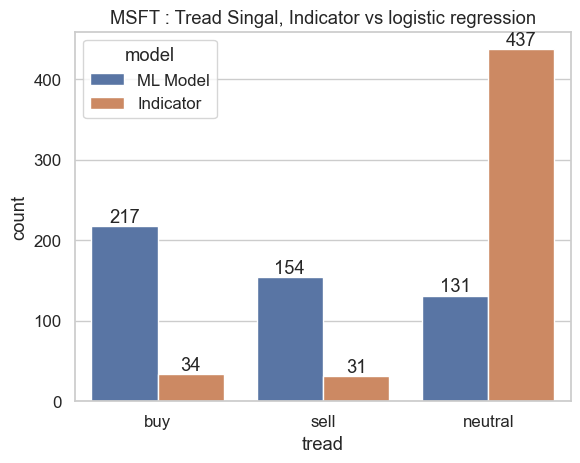

MSFT WMA VPT Signal : Final Profit: $278.94, 2.79%

MSFT logistic regression Signal : Final Profit: $7277.31, 72.77%


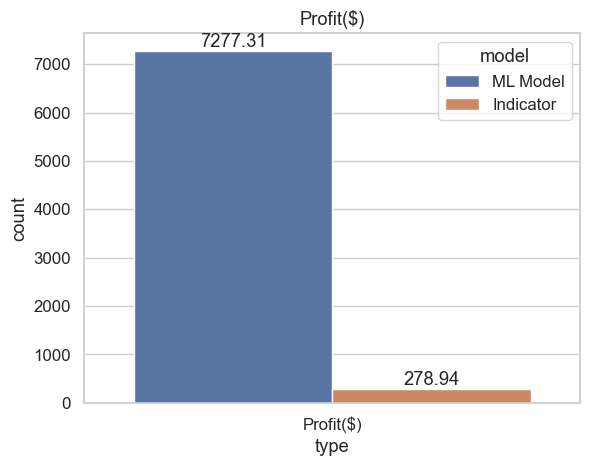

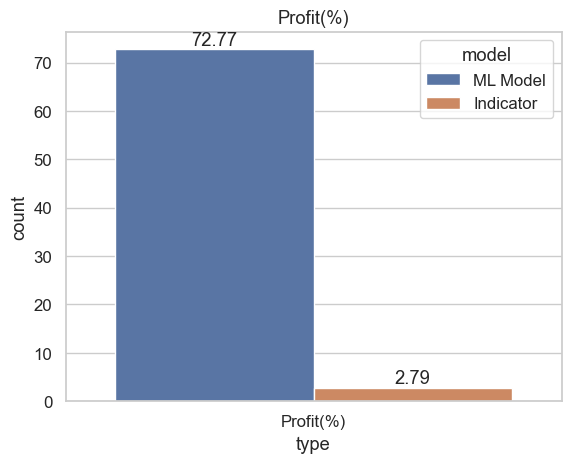

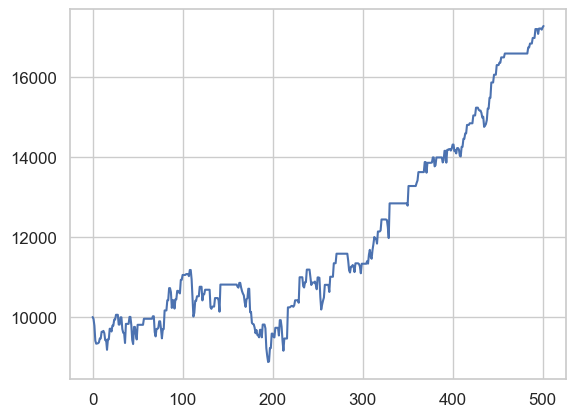

In [17]:
importlib.reload(plots)
importlib.reload(ml)
# Feature columns
features = ["WMA_pct_change","VPT EMA Signal Line diff",'adj_close_pct_change']
# Target column
target = "WMA VPT Signal"
# Create Helper class object for LogisticRegression
ml_lr =  ml.LogisticRegressionHelper()

# Train the model
#lr_models, scaler = ml_lr.train_logistic_regression_model(training_stock_df_with_indecators_MSFT,features,target)
#print_profit("MSFT","logistic regression",ml_lr,lr_models,scaler,testing_stock_df_with_indecators_MSFT,features)

# from saved model
print_profit("MSFT","logistic regression",ml_lr,None,None,testing_stock_df_with_indecators_MSFT,features)

## GradientBoostClassifier

Not none
 0    417
 1     54
-1     31
Name: count, dtype: int64


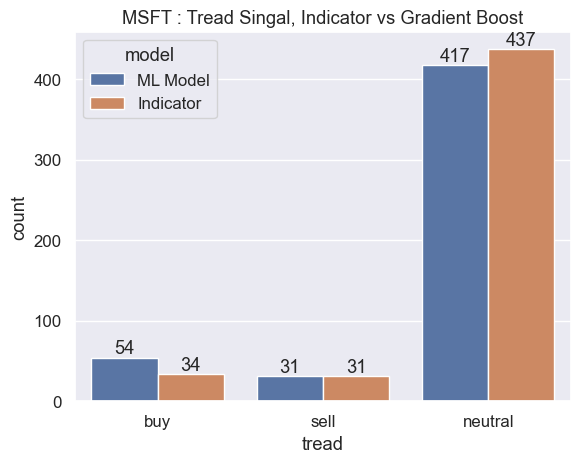

MSFT WMA VPT Signal : Final Profit: $278.94, 2.79%

MSFT Gradient Boost Signal : Final Profit: $3103.93, 31.04%


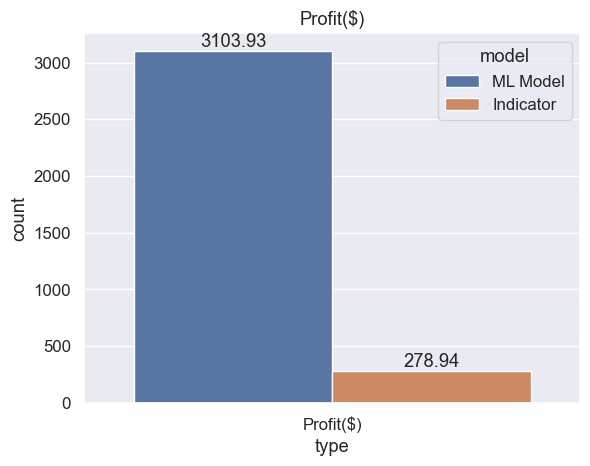

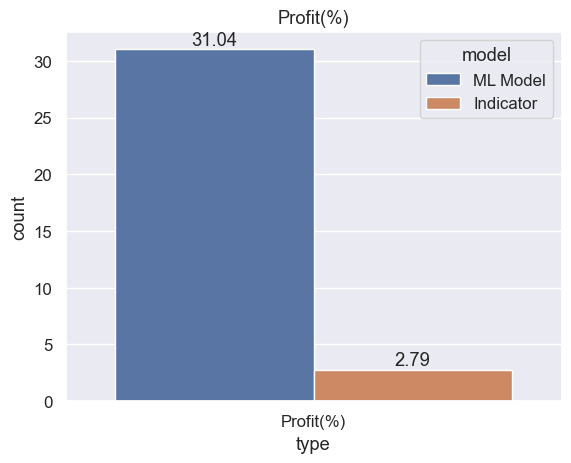

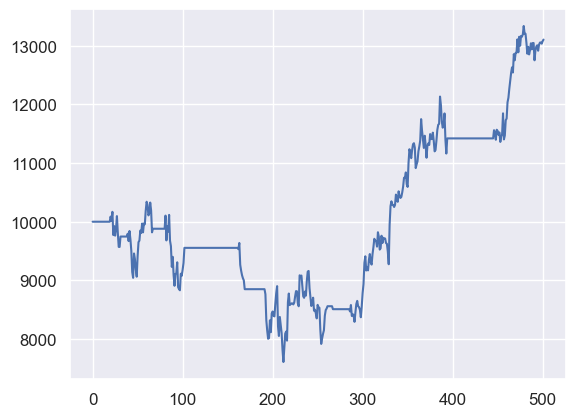

In [10]:

importlib.reload(ml)
# Feature columns
features = ["WMA_pct_change","VPT EMA Signal Line diff",'adj_close_pct_change']
# Target column
target = "WMA VPT Signal"
ml_gb =  ml.GradientBoostClassifierHelper()
#gb_models, scaler = ml_gb.train_gradient_classifier_model(training_stock_df_with_indecators_MSFT,features,target)
#print_profit("MSFT","Gradient Boost",ml_gb,gb_models,scaler,testing_stock_df_with_indecators_MSFT,features)
print_profit("MSFT","Gradient Boost",ml_gb,None,None,testing_stock_df_with_indecators_MSFT,features)

## LSTM

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 28, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 150)            │       120,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,105 (543.38 KB)

 Trainable params: 139,103 (543.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Not none
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
 1    296
 0     94
-1     84
Name: count, dtype: int64


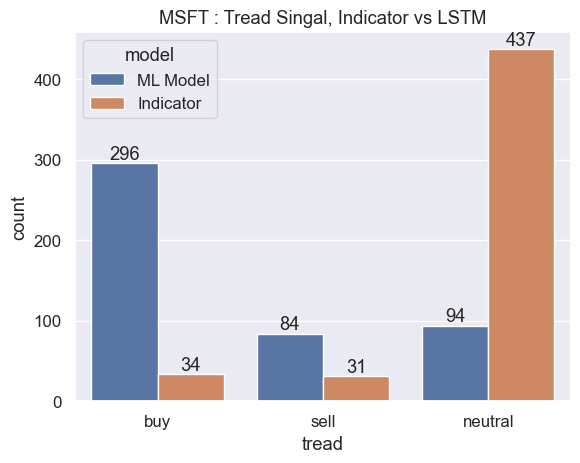

MSFT WMA VPT Signal : Final Profit: $278.94, 2.79%

MSFT LSTM Signal : Final Profit: $1191.20, 11.91%


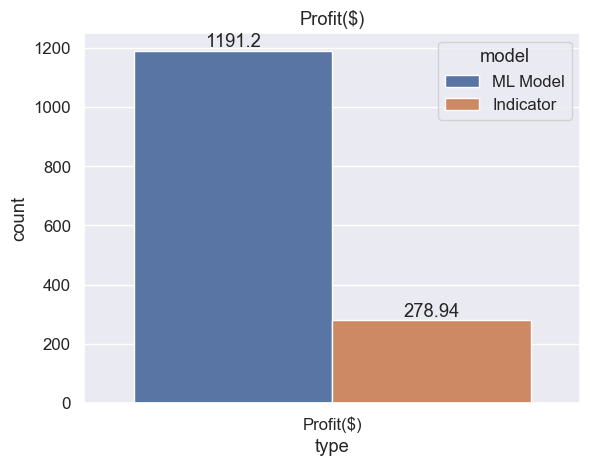

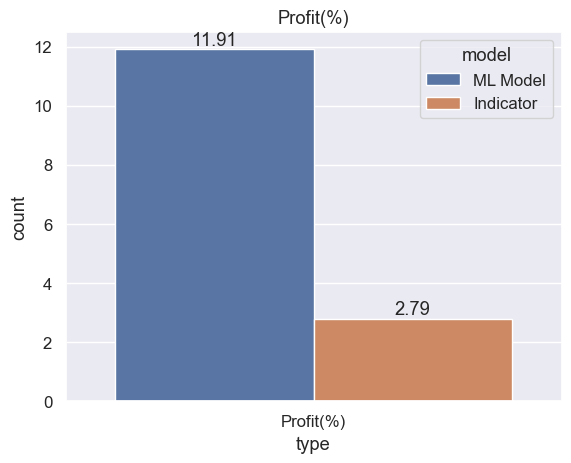

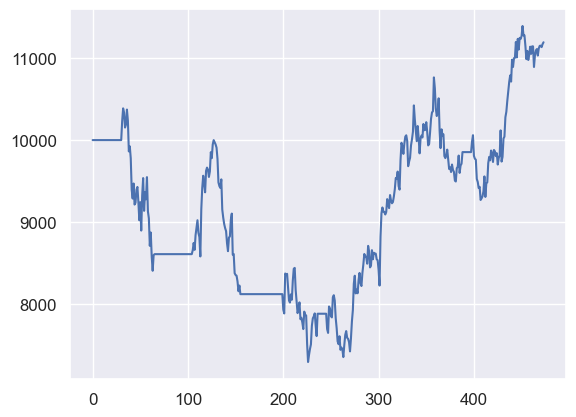

In [11]:
importlib.reload(ml)
import pickle
from tensorflow.keras.models import load_model

ml_lstm = ml.LongShortTermMemoryMLHelper()
#'adj_close_diff', 'WMA_diff',"VPT_diff","RSI_diff"
features = ["WMA_pct_change","VPT EMA Signal Line diff",'adj_close_pct_change']
target = "WMA VPT Signal"
time_step = 28
ml_lstm.dataset1=[]

#lstm_models, scaler = ml_lstm.train_lstm_model(training_stock_df_with_indecators_MSFT,features,target,time_step)
with open('scaler_lstm.pkl','rb') as f:
    scaler = pickle.load(f)

lstm_models = load_model("lstm_stock_prediction_model_50_150_50_28_best_witout_DO.h5")
lstm_models.summary()
ml_lstm.time_step = time_step
print_profit("MSFT","LSTM",ml_lstm,lstm_models,scaler,testing_stock_df_with_indecators_MSFT,features)